#  Forecasting taxi orders

**Objectives**
- We have historical data on taxi orders at airports. 
- It is required to predict the number of taxi orders for the next hour.
- Target metric RMSE less than 48

In [1]:
#pip install Prophet

In [2]:
import IPython
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, train_test_split, KFold, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.base import BaseEstimator
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.signal import rfft
from prophet import Prophet

## Preparing

In [3]:
try:
    data = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


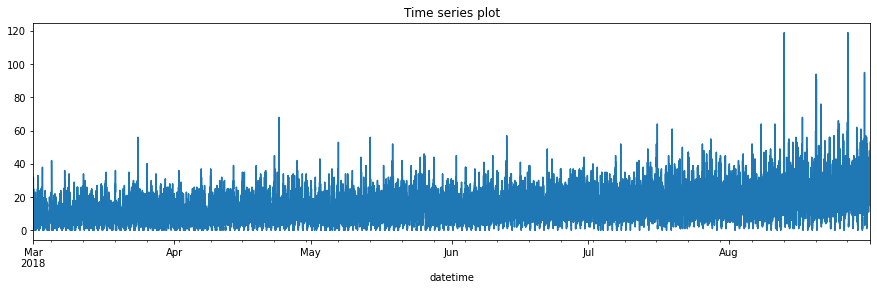

In [5]:
data.plot(figsize=(15,4), legend=False, title='Time series plot');

## Preprocessing
- chronological order, resampling
- check and correct types
- processing null values
- search for outliers and anomalies
- stationarity test, power or logarithmic transformation, differentiation

In [6]:
print(data.index.is_monotonic)

True


In [7]:
data = data.resample('1H').sum()
data.shape

(4416, 1)

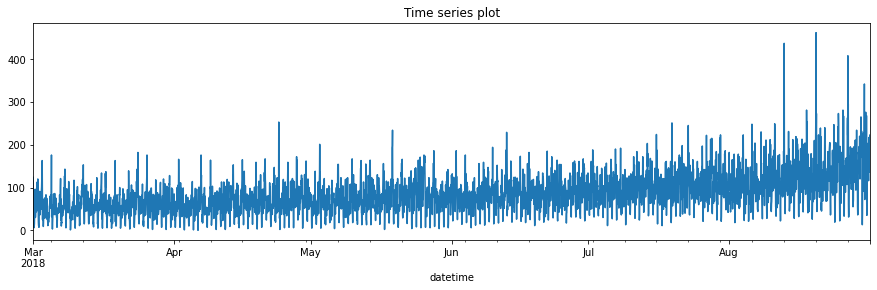

In [8]:
data.plot(figsize=(15,4), legend=False, title='Time series plot');

In [9]:
# outlies?
data[data['num_orders'] > 300]

,num_orders
datetime,
2018-08-13 02:00:00,437
2018-08-20 02:00:00,462
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342


The first three rows were on the same day of the week and at the same hour. Perhaps, it's a new flight. These values will not fall into the training sample and learning will not depend on them, but only the metric on the test and maybe on vividation. There no problems.

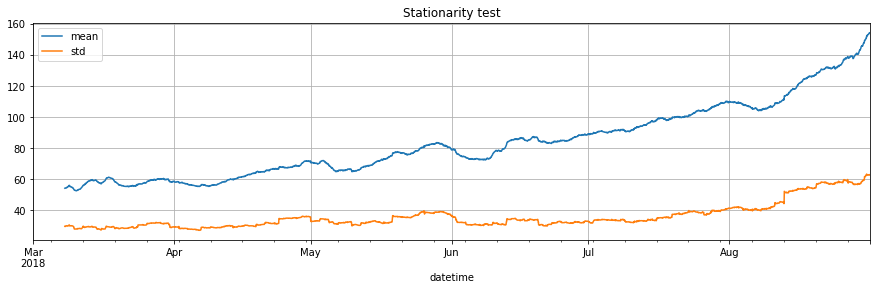

In [10]:
df = data.copy()
df['mean'] = df['num_orders'].rolling(168).mean()
df['std'] = df['num_orders'].rolling(168).std()
df[['mean', 'std']].plot(figsize=(15,4), title='Stationarity test', grid=True);

In [12]:
print('p-value = ', adfuller(data['num_orders'])[1])

p-value =  0.0289400514026132


P-value less than 0.05, which corresponds to the rejection of the hypothesis that the series is non-stationary.

**Resume**

We have stationary time series from March to September of the one year without null values and outliers.

## Feature Engineering
- add new features (year, day of the week, rollig mean, etc.)
- transformations of variables, cyclic variables
- creation of lag features (the number will be specified during the analysis)
- checking for external featues (maybe we can get flight schedules or information about major events from external sources)
- decomposition
- frequency analysis

In [11]:
data['dayofweek'] = data.index.dayofweek
data["dayofyear"] = data.index.dayofyear
data["week"] = data.index.isocalendar().week.astype(int)
data['hour'] = data.index.hour

2022-12-06 12:57:13.969351: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


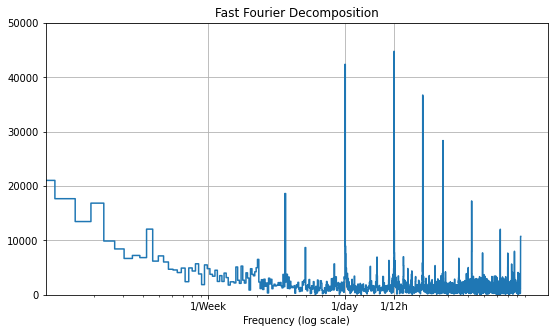

In [12]:
fft = rfft(data['num_orders'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['num_orders'])
hours_per_week = 24*7
week_per_dataset = n_samples_h/(hours_per_week)

f_per_week = f_per_dataset/week_per_dataset
plt.figure(figsize=(9,5))
plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 50000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 7, 14], labels=['1/Week', '1/day', '1/12h'])
plt.xlabel('Frequency (log scale)')
plt.grid()
plt.title('Fast Fourier Decomposition');

- We see the expected frequency once a day. 
- No weekly frequency detected. 
- It is also strange that the half-day frequency is more pronounced than the daily frequency. 
- The remaining higher frequencies are minor harmonics. 
- Let's do some additional analysis

In [13]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None, show_labels=False, alpha=1.0):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette('husl', n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
        alpha = alpha
    )
    ax.set_title(f'Seasonal Plot ({period}/{freq})')
    if show_labels:
        for line, name in zip(ax.lines, X[period].unique()):
            y_ = line.get_ydata()[-1]
            ax.annotate(
                name,
                xy=(1, y_),
                xytext=(6, 0),
                color=line.get_color(),
                xycoords=ax.get_yaxis_transform(),
                textcoords='offset points',
                size=14,
                va='center',
            )
    return ax

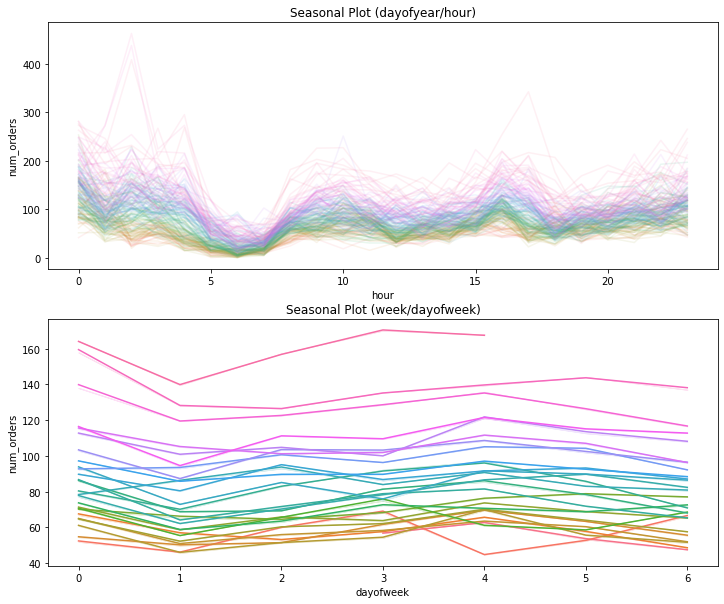

In [14]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 10))
seasonal_plot(data, y='num_orders', period='dayofyear', freq='hour', ax=ax0, alpha=0.1)

df = data.resample('1D').sum()
df['dayofweek'] = df.index.dayofweek
df["week"] = df.index.isocalendar().week.astype(int)
seasonal_plot(data, y='num_orders', period='week', freq='dayofweek', ax=ax1);

- There is a daily pattern, but it is wrong to count it with a period of 12 hours. At night people use taxis more as there is no other transport available. By the morning the flights are getting smaller and the demand is less. There are pronounced rises around 10 a.m. and 4 p.m.
- 0h corresponds to 23h, the feature is cyclic, we will transform
- The week pattern also expect. But there are also conflicting lines
- The feature of the day of the week is also cyclic, but not to the same extent as the time of day, let's leave it unchanged

In [15]:
# transform hour to cyclic
data['sin_hour'] = np.sin(data['hour'] * (2 * np.pi / 24))
data['cos_hour'] = np.cos(data['hour'] * (2 * np.pi / 24))

In [16]:
# for the rolling mean, take a rooling value 24 hours to smooth out the main seasonality and show the trend
# shift to 1, not to look into the future
data['rolling_mean'] = data['num_orders'].rolling(24).mean().shift(1)

We cannot get external signs in this project

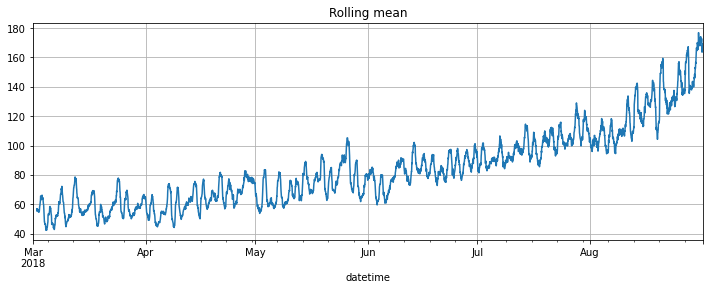

In [17]:
data['rolling_mean'].plot(figsize=(12,4), title='Rolling mean', grid=True);

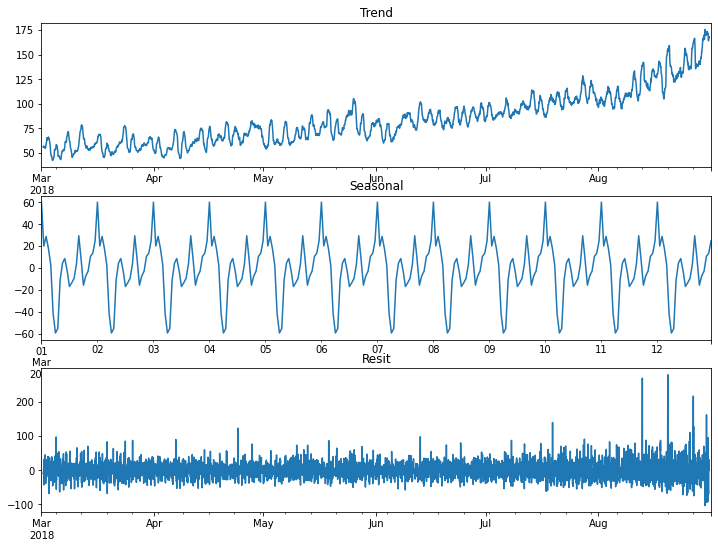

In [18]:
decomposed = seasonal_decompose(data['num_orders'])
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12, 9))
decomposed.trend.plot(title='Trend', xlabel='', ax=ax0);
decomposed.seasonal.head(24*12).plot(title='Seasonal', xlabel='', ax=ax1);
decomposed.resid.plot(title='Resit', xlabel='', ax=ax2);

In [19]:
decomposed.resid.std()

24.696895960143483

**Resume**
- There are large resit, not explained by the trend and seasonality. But at the same time, you need to predict only one hour ahead and the allowable error is almost twice as much.
- Rolling mean normally describes the trend

### Consulation
- new features are added
- checked frequency components 
- checked trend, seasonality and resit

## Exploratory Data Analysis
Let's try to get new knowledge
- correlation matrix
- feature analysis
- Lag plot, Autocorrelation Function (ACF), Partial Autocorrelation Function (PACF) <br>

We have previously discovered
- There is a daily pattern, but it is wrong to count it with a period of 12 hours. At night people use taxis more as there is no other transport available. By the morning the flights are getting smaller and the demand is less. There are pronounced rises around 10 a.m. and 4 p.m.
- 0h corresponds to 23h, the feature is cyclic, we will transform
- The week pattern also expect. But there are also conflicting lines
- The feature of the day of the week is also cyclic, but not to the same extent as the time of day, let's leave it unchanged

In [20]:
data[['num_orders', 'dayofweek', 'hour']].corr()

,num_orders,dayofweek,hour
num_orders,1.000000,-1.962844e-02,4.292046e-03
dayofweek,-0.019628,1.000000e+00,2.160411e-18
hour,0.004292,2.160411e-18,1.000000e+00


There no linear correlation between features

**Lag plot** - scatter plot where x is value and y is lagged value

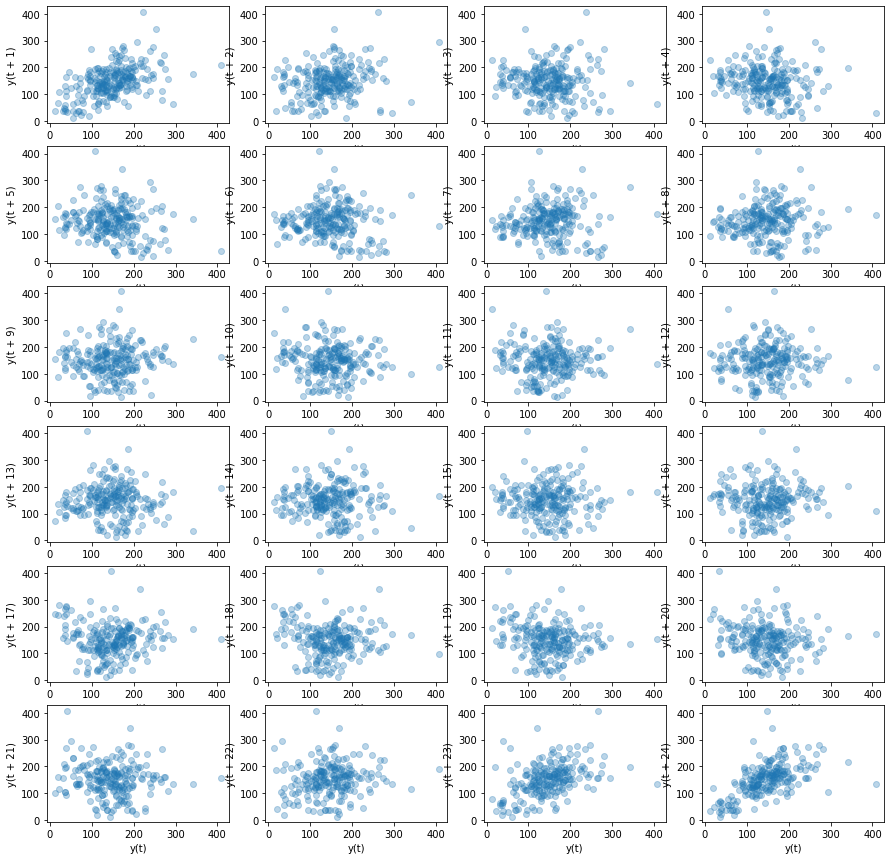

In [21]:
axes = plt.subplots(6, 4, figsize=(15, 15))[1];
for i in range(24):
    pd.plotting.lag_plot(data['num_orders'].tail(240), lag=i+1, ax = axes[i // 4][i % 4], alpha=0.3);

**Autocorrelation function (ACF)** — the correlation of a signal with a delayed copy

**Partial autocorrelation function (PACF)** —  partial correlation of a stationary time series with its own lagged values. This function show new contribution for each lags

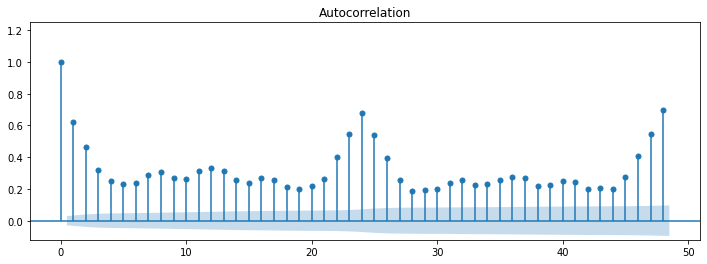

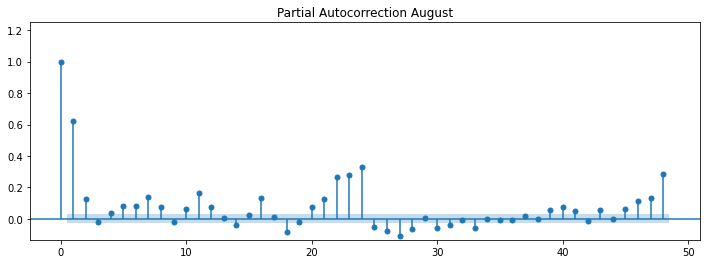

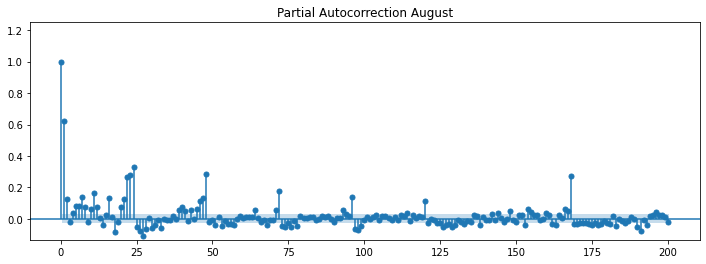

In [22]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(12,4))
    plot_acf(data['num_orders'], lags=48, auto_ylims=True);
    plot_pacf(data['num_orders'], lags=48, auto_ylims=True, 
              method='ywm', title='Partial Autocorrection August');
    plot_pacf(data['num_orders'], lags=200, auto_ylims=True, 
              method='ywm', title='Partial Autocorrection August');


Thus, we take a lag [1, 23, 24, 168], which corresponds to good explainability: the last hour, a day ago, the next hour after a day ago (like an hour after a prediction a day ago) and a week ago

In [23]:
data['lag_1'] = data['num_orders'].shift(1)
data['lag_23'] = data['num_orders'].shift(23)
data['lag_24'] = data['num_orders'].shift(24)
data['lag_168'] = data['num_orders'].shift(168)
# data = data.dropna() # we will do it later

### Consulation
- the analysis of autocorrelation was carried out and features of lags were selected
- collected general analytical data

## Modeling
- train/valid/test split, CV 
- simple dummy
- algorithmic model just for try or LR (baseline)
- LGBM / XGB
- Prophet

### Test train split

In [25]:
df = data.dropna().reset_index(drop=True)
df_f = df[['dayofweek', 'sin_hour', 'cos_hour', 'rolling_mean', 'lag_1', 'lag_23', 'lag_24', 'lag_168']]
df_t = df['num_orders']

train_f, test_f = train_test_split(df_f, shuffle=False, test_size=0.1)
train_t, test_t = train_test_split(df_t, shuffle=False, test_size=0.1)

print(train_f.shape)
print(train_t.shape)
print(test_f.shape)
print(test_t.shape)

(3823, 8)
(3823,)
(425, 8)
(425,)


In [26]:
stat = {}

def CV(model, X, y, params = {}, split = 'default', n_splits=5, suffix=''):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    grid = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=tscv)
    grid.fit(X, y)
    
    score = (-grid.best_score_) ** 0.5
    name = repr(grid.best_estimator_)
    if suffix != '':
        name = suffix + ' ' + name
    stat[name] = (grid.best_estimator_, score)
    
    return grid.best_estimator_, score    

### Dummy

In [27]:
class DummyModel(BaseEstimator):
    def __init__(self, column = None):
        self.column = column
        
    def fit(self, X, y):
        return
    
    def predict(self, X):
        return X[self.column]

In [28]:
CV(DummyModel(), train_f, train_t, 
   params={'column': ['rolling_mean', 'lag_1', 'lag_24', 'lag_168']})

(DummyModel(column='lag_168'), 26.567138966050603)

**Resume**, Dummy for repeat week ago value has no bad metric) We will improve that

### LR
- After some research, the algorithmic model was reduced to LR
- We will use the lags expected above (1, 23, 24, 168)

In [29]:
class LRModel(BaseEstimator):
    def __init__(self, columns = None):
        self.columns = columns
        
    def fit(self, X, y):
        self.model = LinearRegression()
        if self.columns != None:
            self.model.fit(X[self.columns], y)
        else:
            self.model.fit(X, y)
        return
    
    def predict(self, X):
        if self.columns != None:
            return self.model.predict(X[self.columns])
        else:
            return self.model.predict(X)

In [32]:
m,s = CV(LRModel(['lag_1', 'lag_23', 'lag_24', 'lag_168']), train_f, train_t)
s

23.474370394095093

In [33]:
m.model.coef_

array([0.15780945, 0.07457414, 0.20731757, 0.54546466])

In [34]:
m,s = CV(LRModel(['lag_1', 'lag_24', 'lag_168']), train_f, train_t)
s

23.593781320242027

In [35]:
m.model.coef_

array([0.15887384, 0.24076224, 0.55810748])

In [39]:
# for future
df = data.copy()
df = df.drop(columns=[x for x in df.columns if x != 'num_orders'])
for i in range(168):
    df[f'lag_{i+1}'] = df['num_orders'].shift(i+1)
df=df.dropna()
    
train168_f, test168_f = train_test_split(df.drop(columns=['num_orders']), shuffle=False, test_size=0.1)
train168_t, test168_t = train_test_split(df['num_orders'], shuffle=False, test_size=0.1)

**Resume**
- LR is better than Dummy (RMSE 23 vs 26).
- Adding features other than lag improved the metric by only 0.2% (excluded from project). This result demonstrates well that the majority is predicted by only 4 lag values and allows us to build a simple and interpretable model: <br>
Y(0) = 0.54*Y(-1W) + 0.21*Y(-1D) + 0.16*Y(-1H) + 0.07*Y(-23H)<br>
- And even with almost no loss of accuracy, you can leave only three features and get a very simple formula:<br>
Y(0) = 0.56*Y(-1W) + 0.24*Y(-1D) + 0.16*Y(-1H)<br>

### LGBM

In [36]:
class LGBMModel(BaseEstimator):
    
    def __init__(self, max_depth=10):
        self.max_depth = max_depth
        
    def fit(self, X, y):
        # гиперпараметры подбирались вручную
        self.model = lgb.LGBMRegressor(max_depth=self.max_depth)
        self.model.fit(X, y)
        return
    
    def predict(self, X):
        return self.model.predict(X)

In [37]:
CV(LGBMModel(), train_f, train_t, params = {'max_depth': [2,4,8,11,18]})

(LGBMModel(max_depth=2), 23.478946214154586)

In [40]:
CV(LGBMModel(), train168_f, train168_t, params = {'max_depth': [2,4,8,11,18]}, suffix='168')

(LGBMModel(max_depth=2), 22.83783920656994)

**Resume:** Wow! LR on par with LGRF! but in LGRF we have to select more parameters

In [62]:
val_performance

{'Linear': [1301.60595703125, 36.07777786254883]}

In [63]:
class ProphetModel(BaseEstimator):
    def fit(self, X, y):
        df = pd.DataFrame()
        dt0 = data.dropna().index[0]
        df['y'] = y
        df['ds'] = [dt0 + timedelta(hours=x) for x in X.index]
        
        self.model = Prophet()
        self.model.fit(df)
        return
    
    def predict(self, X):
        future = pd.DataFrame()
        dt0 = data.dropna().index[0]
        future['ds'] = [dt0 + timedelta(hours=x) for x in X.index]
        
        forecast = self.model.predict(future)
        return forecast['yhat']

In [64]:
CV(ProphetModel(), train_f, train_t)[1]

13:39:37 - cmdstanpy - INFO - Chain [1] start processing
13:39:38 - cmdstanpy - INFO - Chain [1] done processing
13:39:39 - cmdstanpy - INFO - Chain [1] start processing
13:39:39 - cmdstanpy - INFO - Chain [1] done processing
13:39:40 - cmdstanpy - INFO - Chain [1] start processing
13:39:40 - cmdstanpy - INFO - Chain [1] done processing
13:39:41 - cmdstanpy - INFO - Chain [1] start processing
13:39:41 - cmdstanpy - INFO - Chain [1] done processing
13:39:42 - cmdstanpy - INFO - Chain [1] start processing
13:39:43 - cmdstanpy - INFO - Chain [1] done processing
13:39:44 - cmdstanpy - INFO - Chain [1] start processing
13:39:44 - cmdstanpy - INFO - Chain [1] done processing


27.890959162555315

### Prophet

**Выводы**
- Много интересных параметров в предсказании
- Простое использование
- В этом простом примере не раскрыт потенциал библиотеки. Скорее всего результат можно улучишить

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b> 👍 
</div>

In [74]:
tail_train_f, tail_valid_f = train_test_split(train_f, shuffle=False, test_size=0.2)
tail_train_t, tail_valid_t = train_test_split(train_t, shuffle=False, test_size=0.2)

length = 31*24
tail_train_f = tail_train_f.tail(length)
tail_train_t = tail_train_t[0:length]

model = LinearRegression()
model.fit(tail_train_f, tail_train_t)

score = mean_squared_error(tail_valid_t, model.predict(tail_valid_f)) ** 0.5
score

67.62474196818222

## Testing

In [65]:
stat

{"DummyModel(column='lag_168')": (DummyModel(column='lag_168'),
  26.567138966050603),
 "LRModel(columns=['lag_1', 'lag_23', 'lag_24', 'lag_168'])": (LRModel(columns=['lag_1', 'lag_23', 'lag_24', 'lag_168']),
  23.474370394095093),
 "LRModel(columns=['lag_1', 'lag_24', 'lag_168'])": (LRModel(columns=['lag_1', 'lag_24', 'lag_168']),
  23.593781320242027),
 'LGBMModel(max_depth=2)': (LGBMModel(max_depth=2), 23.478946214154586),
 '168 LGBMModel(max_depth=2)': (LGBMModel(max_depth=2), 22.83783920656994),
 'TFDenseModel(epochs=10)': (TFDenseModel(epochs=10), 23.6769111538921),
 '168 TFDenseModel(epochs=10)': (TFDenseModel(epochs=10), 25.280869013055145),
 'ProphetModel()': (ProphetModel(), 27.890959162555315)}

In [66]:
def test_model(name):
    model = stat[name][0]
    print(name)
    if "168" in name:
        return mean_squared_error(test168_t, model.predict(test168_f)) ** 0.5
    elif "24" in name or "48" in name or "336" in name or "temp" in name:
        return np.nan
    else:
        return mean_squared_error(test_t, model.predict(test_f)) ** 0.5

In [67]:
stat_df = pd.DataFrame()
stat_df['Name'] = stat.keys()
stat_df['CV'] = stat_df['Name'].apply(lambda x: stat[x][1])

stat_df.sort_values(by='CV')

,Name,CV
4,168 LGBMModel(max_depth=2),22.837839
1,"LRModel(columns=['lag_1', 'lag_23', 'lag_24', ...",23.474370
3,LGBMModel(max_depth=2),23.478946
2,"LRModel(columns=['lag_1', 'lag_24', 'lag_168'])",23.593781
5,TFDenseModel(epochs=10),23.676911
6,168 TFDenseModel(epochs=10),25.280869
0,DummyModel(column='lag_168'),26.567139
7,ProphetModel(),27.890959


Если подходить формально, то лучшая модель `LGBM 168 lags`. Проверим её на тесте

In [68]:
# the best model
test_model('168 LGBMModel(max_depth=2)')

168 LGBMModel(max_depth=2)


37.54233047629424

### Вывод
- Лучшая модель на CV `168 LGBMModel(max_depth=2)`. Результат на тесте удовлетворяет заданию
- Мне очень понравились простые модели LR, особенно самая простая с тремя входами. И на самом деле они даже показывают лучше результат на тесте
- Сложные модели, такие как CNN, RNN, Prophet наверное не смогли раскрыть сови возможнсоти по причине простого датасета и необходимости в тщательной настройке. Но разобраться в них полезно
- Модель Prophet можно так же использовать для анализа данных. Но опять же, ручной анализ с пониманием доменной области может оказаться значительно эффективнее

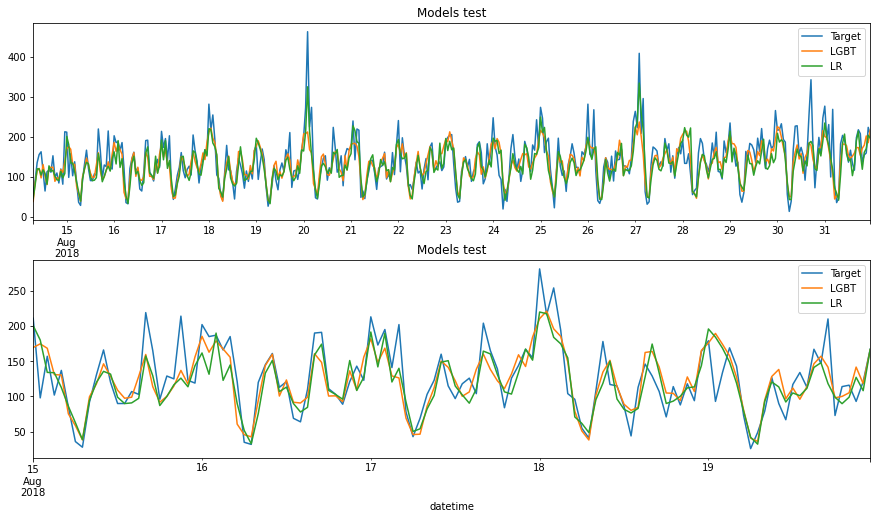

In [70]:
df = pd.DataFrame(index = test168_t.index)
df['Target'] = test_t.to_numpy()
df['LGBT'] = stat['168 LGBMModel(max_depth=2)'][0].predict(test168_f)
df['LR'] = stat["LRModel(columns=['lag_1', 'lag_24', 'lag_168'])"][0].predict(test168_f)

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 8))
df.plot(title='Models test', ax=ax0);
df['2018-08-15':'2018-08-19'].plot(title='Models test', ax=ax1);

## Consulation
- the required goals have been achieved, the metric is better than the minimum required

**Выводы по подготовке и предобработке**
- Мы имеем нестационарный ряд с марта до сентября одного года, без пропусков.
- есть дневная закономерность, но её неправильно считать с периодом в 12ч. Ночью люди больше пользуются такси, так как нет другого доступного транспорта. К утру рейсов становится меньши и спрос меньше. Есть выраженные подъемы в окрестности 10ч и 16ч
- закономерности по дням недели есть, как и следовало ожидать. Но есть и противоречащие линии. Вцелом, признак можно оставить
- Достаточно большой остаток, не объясняемый трендом и сезонностью. Но в тоже время нужно предсказать всего на один час вперед и допустимая погрешность почти в двое больше.
- Скользящее среднее нормально описывает тренд
- Достаточно большой остаток, не объясняемый трендом и сезонностью. Но в тоже время нужно предсказать всего на один час вперед и допустимая погрешность почти в двое больше.
- Скользящее среднее нормально описывает тренд
- проведен анализ автокорреляции и выбраны признаки задержки
- собраны общие аналитические данные

**Выводы по обучению**
- Проведено моделирование нескольких типов моделей
- Мне очень понравились простые модели LR, особенно на самая простая с тремя входами. И на самом деле они даже показывают лучше результат на тесте
- Сложные модели, такие как CNN, RNN, Prophet наверное не смогли раскрыть свои возможнсоти по причине простого датасета и необходимости в тщательной настройке. Но разобраться в них полезно
- Модель Prophet можно так же использовать для анализа данных. Но опять же, ручной анализ с пониманием доменной области может оказаться значительно эффективнее

**Вывводы по тестированию и выбору модели**
- Лучшая модель на CV `168 LGBMModel(max_depth=2)`. Результат на тесте удовлетворяет заданию